# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [40]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as py
import seaborn as sns
import datetime
import re

from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import avg, col, concat, desc, explode, lit, min, max, split, udf, isnull
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import sum as Fsum
from pyspark.sql import types as sT

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, DecisionTreeClassifier, NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, PCA, RegexTokenizer, StandardScaler, StopWordsRemover, StringIndexer, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder


In [41]:
# create a Spark session
spark = SparkSession.builder.appName("Sparkify").getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [42]:
sparkify_data = 'mini_sparkify_event_data.json'
df = spark.read.json(sparkify_data)
df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')

In [43]:
df.columns

['artist',
 'auth',
 'firstName',
 'gender',
 'itemInSession',
 'lastName',
 'length',
 'level',
 'location',
 'method',
 'page',
 'registration',
 'sessionId',
 'song',
 'status',
 'ts',
 'userAgent',
 'userId']

In [44]:
df.show(5)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Boston-Cambridge-...|   PUT|NextSong|1538331630000| 

In [45]:
print('Length of df: ' + str(df.count()))
print('Number of columns: '+ str(len(df.columns)))

Length of df: 286500
Number of columns: 18


In [46]:
# drop nan values
df = df.dropna(how='any', subset=['userId', 'sessionId'])

In [47]:
# look for empty strings as user ids
df.select('userId').dropDuplicates().sort('userId').show()

+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
|100008|
|100009|
|100010|
|100011|
|100012|
|100013|
|100014|
|100015|
|100016|
|100017|
+------+
only showing top 20 rows



In [48]:
df = df.filter(df['userId'] != '')
print('Length of df: ' + str(df.count()))

Length of df: 278154


In [49]:
# look for empty strings in session id as well
df.select('sessionId').dropDuplicates().sort('userId').show()

+---------+
|sessionId|
+---------+
|     1981|
|        9|
|     1047|
|     1592|
|      595|
|     1414|
|     1782|
|     1210|
|     1279|
|     1505|
|     2240|
|     1185|
|      556|
|     1299|
|     1473|
|     1760|
|     1899|
|     1353|
|      369|
|     1967|
+---------+
only showing top 20 rows



# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [50]:
df.select("page").dropDuplicates().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



In [51]:
# just exploring the differnt account types for pages
df.select(['page', 'level']).show()

+---------------+-----+
|           page|level|
+---------------+-----+
|       NextSong| paid|
|       NextSong| free|
|       NextSong| paid|
|       NextSong| free|
|       NextSong| paid|
|       NextSong| free|
|       NextSong| free|
|       NextSong| paid|
|Add to Playlist| paid|
|       NextSong| paid|
|       NextSong| free|
|    Roll Advert| free|
|       NextSong| paid|
|       NextSong| free|
|      Thumbs Up| free|
|       NextSong| paid|
|       NextSong| free|
|       NextSong| free|
|       NextSong| paid|
|       NextSong| free|
+---------------+-----+
only showing top 20 rows



In [52]:
# we can confirm cancellation confirmation happens for both free and paid accoutns
df.filter(df.page == 'Cancellation Confirmation').select(['userId', 'level']).show(10)

+------+-----+
|userId|level|
+------+-----+
|    18| paid|
|    32| paid|
|   125| free|
|   105| paid|
|    17| paid|
|   143| free|
|   101| paid|
|   129| paid|
|   121| paid|
|    51| paid|
+------+-----+
only showing top 10 rows



In [53]:
# let's look more columns for a user that has cancellation confirmation to explore which will be most useful to us
df.filter(df.page == 'Cancellation Confirmation').select(['userId', 'level', 'length', 'method', 'song', 'status', \
                                                          'ts', 'registration', 'gender', 'sessionId', \
                                                          'location', 'itemInSession']).show(10)

+------+-----+------+------+----+------+-------------+-------------+------+---------+--------------------+-------------+
|userId|level|length|method|song|status|           ts| registration|gender|sessionId|            location|itemInSession|
+------+-----+------+------+----+------+-------------+-------------+------+---------+--------------------+-------------+
|    18| paid|  null|   GET|null|   200|1538943990000|1535623466000|     M|      514|  Kansas City, MO-KS|          104|
|    32| paid|  null|   GET|null|   200|1539033046000|1537167593000|     M|      540|Phoenix-Mesa-Scot...|           56|
|   125| free|  null|   GET|null|   200|1539318918000|1533157139000|     M|      174|  Corpus Christi, TX|           10|
|   105| paid|  null|   GET|null|   200|1539375441000|1536817381000|     M|      508|Indianapolis-Carm...|          332|
|    17| paid|  null|   GET|null|   200|1539465584000|1538333829000|     F|      797|Philadelphia-Camd...|          273|
|   143| free|  null|   GET|null

We see here that there are a bunch of different users with cancellation confirmation status. We will have to look into the length column because everything seems to be null, which will not be useful for us in building our model. I also don't think that the method or status will be of much use, but we can keep investigating.

In [54]:
#looking into an individual user and different columns
df.select(["userId", "page", 'auth', "level", "song", "sessionId"]).where(df.userId == "18").sort("sessionId").show(50)

+------+---------------+---------+-----+--------------------+---------+
|userId|           page|     auth|level|                song|sessionId|
+------+---------------+---------+-----+--------------------+---------+
|    18|           Home|Logged In| paid|                null|      242|
|    18|       NextSong|Logged In| paid|A Beggar On A Bea...|      242|
|    18|       NextSong|Logged In| paid|...slowdance On T...|      242|
|    18|       NextSong|Logged In| paid|       St. Apollonia|      242|
|    18|       NextSong|Logged In| paid|      Drunk Stripper|      242|
|    18|       NextSong|Logged In| paid|In League With Satan|      242|
|    18|       Settings|Logged In| paid|                null|      242|
|    18|       NextSong|Logged In| paid|           The Quest|      242|
|    18|       NextSong|Logged In| paid|    Waking The Demon|      242|
|    18|       NextSong|Logged In| paid|Why Do You Let Me...|      242|
|    18|       NextSong|Logged In| paid|High (Album Version)|   

In [55]:
# there are 225 unique users in the entire datasett
df.select('userId').dropDuplicates().count()

225

In [56]:
#there are only 52 unique users with cancellation confirmation
churn_ids = df.filter(df.page == 'Cancellation Confirmation').select('userId').dropDuplicates()
churn_ids.count()

52

In [57]:
#Let's create a column that flags whether or not a user has cancellation confirmation status
churn_flag = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
df = df.withColumn('churn', churn_flag('page'))

windowval = Window.partitionBy("userId").rangeBetween(Window.unboundedPreceding, Window.unboundedFollowing)
df = df.withColumn("churn", Fsum("churn").over(windowval))
df.take(2)

[Row(artist='Sleeping With Sirens', auth='Logged In', firstName='Darianna', gender='F', itemInSession=0, lastName='Carpenter', length=202.97098, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='NextSong', registration=1538016340000, sessionId=31, song='Captain Tyin Knots VS Mr Walkway (No Way)', status=200, ts=1539003534000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', churn=0),
 Row(artist='Francesca Battistelli', auth='Logged In', firstName='Darianna', gender='F', itemInSession=1, lastName='Carpenter', length=196.54485, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='NextSong', registration=1538016340000, sessionId=31, song='Beautiful_ Beautiful (Album)', status=200, ts=1539003736000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0

In [58]:
# sanity check that adding our column returns only 52 unique users again
print('Number of users who cancelled: ' + str(df.filter(df.churn == 1).select('userId').dropDuplicates().count()))
print('Number of users who stayed: ' + str(df.filter(df.churn == 0).select('userId').dropDuplicates().count()))

Number of users who cancelled: 52
Number of users who stayed: 173


In [59]:
df.dropDuplicates(['userId']).groupby(['churn']).count().show()

+-----+-----+
|churn|count|
+-----+-----+
|    0|  173|
|    1|   52|
+-----+-----+



In [60]:
df.dropDuplicates(['userId', 'level']).groupby(['churn', 'level']).count().show()


+-----+-----+-----+
|churn|level|count|
+-----+-----+-----+
|    1| paid|   36|
|    1| free|   46|
|    0| free|  149|
|    0| paid|  129|
+-----+-----+-----+



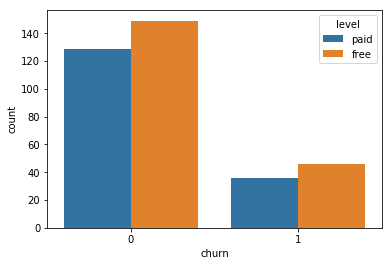

In [200]:
acct = df.dropDuplicates(['userId', 'level']).groupby(['churn', 'level']).count().toPandas()
sns.barplot(x='churn', y='count', hue='level', data=acct)

In [197]:
df.dropDuplicates(['userId', 'gender']).groupby(['churn', 'gender']).count().show()

+-----+------+-----+
|churn|gender|count|
+-----+------+-----+
|    0|     F|   84|
|    1|     M|   32|
|    1|     F|   20|
|    0|     M|   89|
+-----+------+-----+



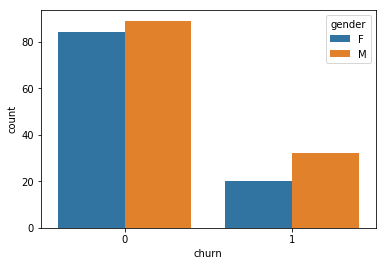

In [198]:
gend = df.dropDuplicates(['userId', 'gender']).groupby(['churn', 'gender']).count().toPandas()
sns.barplot(x='churn', y='count', hue='gender', data=gend)

In [62]:
df.dropDuplicates(['userId', 'location']).groupby(['churn', 'location']).count().orderBy('count').show(25000)


+-----+--------------------+-----+
|churn|            location|count|
+-----+--------------------+-----+
|    0|Santa Maria-Santa...|    1|
|    0|Louisville/Jeffer...|    1|
|    0|         Raleigh, NC|    1|
|    0|     Bakersfield, CA|    1|
|    1|  Corpus Christi, TX|    1|
|    0|         Boulder, CO|    1|
|    0|        Billings, MT|    1|
|    0|         Salinas, CA|    1|
|    1|Dallas-Fort Worth...|    1|
|    1|   Memphis, TN-MS-AR|    1|
|    0|   Winston-Salem, NC|    1|
|    1|San Diego-Carlsba...|    1|
|    0|           Price, UT|    1|
|    0|Detroit-Warren-De...|    1|
|    0|Greensboro-High P...|    1|
|    0|Baltimore-Columbi...|    1|
|    0|   Stockton-Lodi, CA|    1|
|    1|          London, KY|    1|
|    1|Colorado Springs, CO|    1|
|    0|            Napa, CA|    1|
|    0|        Danville, VA|    1|
|    1|Albany-Schenectad...|    1|
|    1|           Selma, AL|    1|
|    0|         Pontiac, IL|    1|
|    0|            Troy, AL|    1|
|    0|       Anchor

In [63]:
df.select('auth').dropDuplicates().show()

+---------+
|     auth|
+---------+
|Cancelled|
|Logged In|
+---------+



In [64]:
#let's create dataframe for what columns we think will be important to our model
df_clean = df.select(['artist', 'auth', 'gender', 'length', 'level', 'location', \
                     'page', 'sessionId', 'song', 'ts', 'userAgent', 'userId', 'churn'])

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [65]:
# average number of songs
songs_per_session = df_clean.filter(df_clean.page == 'NextSong').groupby('userId', 'sessionId').count()
avg_songs = songs_per_session.groupby('userId').agg(avg(songs_per_session['count']).alias('avgSongPerSession'))
avg_songs.show(5)

+------+------------------+
|userId| avgSongPerSession|
+------+------------------+
|100010|39.285714285714285|
|200002|              64.5|
|   125|               8.0|
|    51|             211.1|
|   124|145.67857142857142|
+------+------------------+
only showing top 5 rows



In [80]:
# number thumbs up
num_thumbs_up = df_clean.filter(df_clean.page == 'Thumbs Up').groupby('UserId').count().withColumnRenamed('count', 'num_thumbs_up')
num_thumbs_up.show(5)

+------+-------------+
|UserId|num_thumbs_up|
+------+-------------+
|100010|           17|
|200002|           21|
|    51|          100|
|   124|          171|
|     7|            7|
+------+-------------+
only showing top 5 rows



In [81]:
# number thumbs down
num_thumbs_down = df_clean.filter(df_clean.page == 'Thumbs Down').groupby('UserId').count().withColumnRenamed('count', 'num_thumbs_down')
num_thumbs_down.show(5)

+------+---------------+
|UserId|num_thumbs_down|
+------+---------------+
|100010|              5|
|200002|              6|
|    51|             21|
|   124|             41|
|     7|              1|
+------+---------------+
only showing top 5 rows



In [93]:
# gender encoding
gender_flag = udf(lambda x: 1 if x == "M" else 0, IntegerType())
gender = df_clean.withColumn('gender', gender_flag('gender'))
gender = gender.select('userId', 'gender').dropDuplicates()
gender.show(5)


+------+------+
|userId|gender|
+------+------+
|    73|     0|
|    37|     1|
|    19|     0|
|   134|     1|
|   139|     1|
+------+------+
only showing top 5 rows



In [92]:
# session length
start = df_clean.groupby('userId', 'sessionId').min('ts').withColumnRenamed('min(ts)', 'start')
end = df_clean.groupby('userId', 'sessionId').max('ts').withColumnRenamed('max(ts)' ,'end')

num_sessions_hrs = start.join(end, ['userId', 'sessionId'])
num_sessions_hrs = num_sessions_hrs.select('userId', 'sessionId', (((num_sessions_hrs.end - num_sessions_hrs.start) / (60*60*1000)).alias('num_sessions_hrs')))
num_sessions_hrs.show(5)

+------+---------+-------------------+
|userId|sessionId|   num_sessions_hrs|
+------+---------+-------------------+
|   101|      635| 55.000277777777775|
|   110|     1776| 1.3908333333333334|
|   120|      627| 15.855555555555556|
|   122|      691|0.30833333333333335|
|   140|      798|0.16027777777777777|
+------+---------+-------------------+
only showing top 5 rows



In [71]:
# number of artists
num_artists = df_clean.filter(df_clean.page == 'NextSong').select('userId', 'artist').dropDuplicates().groupby('userId').count().withColumnRenamed('count', 'num_artists')
num_artists.show(5)

+------+-----------+
|userId|num_artists|
+------+-----------+
|100010|        252|
|200002|        339|
|   125|          8|
|    51|       1385|
|   124|       2232|
+------+-----------+
only showing top 5 rows



In [89]:
#location feature by state
extract_state = udf(lambda x: x.split(',')[1].strip())
state = df_clean.withColumn('stateCd', extract_state(df_clean.location))
state = state.select('userId', 'stateCd').dropDuplicates()
state.show(5)

+------+-------+
|userId|stateCd|
+------+-------+
|    92|  MA-NH|
|    73|     NY|
|200004|     NC|
|300020|     GA|
|   121|     CA|
+------+-------+
only showing top 5 rows



In [115]:
#make numerical for modeling purposes
state_indexer = StringIndexer(inputCol="stateCd",outputCol="stateCd_index")
state_indexed = state_indexer.fit(state).transform(state)

state_indexed.show(7)

+------+-------+-------------+
|userId|stateCd|stateCd_index|
+------+-------+-------------+
|    92|  MA-NH|         10.0|
|    73|     NY|         13.0|
|200004|     NC|          9.0|
|300020|     GA|         17.0|
|   121|     CA|          0.0|
|100017|     AL|         18.0|
|200022|  MO-IL|          8.0|
+------+-------+-------------+
only showing top 7 rows



In [119]:
state_feature = state_indexed.select('userId', 'stateCd_index').dropDuplicates()
state_feature.show(5)

+------+-------------+
|userId|stateCd_index|
+------+-------------+
|     3|         34.0|
|    81|         12.0|
|   132|         16.0|
|300015|          1.0|
|    89|         17.0|
+------+-------------+
only showing top 5 rows



In [90]:
#level encoding
level_flag = udf(lambda x: 1 if x == "paid" else 0, IntegerType())
level = df_clean.withColumn('level', level_flag('level'))
level = level.select('userId', 'level').dropDuplicates()
level.show(5)

+------+-----+
|userId|level|
+------+-----+
|    73|    0|
|    69|    1|
|    37|    1|
|   139|    1|
|300007|    1|
+------+-----+
only showing top 5 rows



In [91]:
# churn
churn = df_clean.select('userId', 'churn').dropDuplicates()
churn.show(5)

+------+-----+
|userId|churn|
+------+-----+
|100010|    0|
|200002|    0|
|   125|    1|
|   124|    0|
|    51|    1|
+------+-----+
only showing top 5 rows



In [141]:
# combining features for model into dataframe
data =  churn.join(avg_songs,'userId') \
    .join(num_thumbs_up, 'userId') \
    .join(num_thumbs_down,'userId') \
    .join(num_sessions_hrs,'userId') \
    .join(num_artists,'userId') \
    .join(gender,'userId') \
    .join(level,'userId') \
    .join(state_feature,'userId') \

data.show(5)

+------+-----+------------------+-------------+---------------+---------+-------------------+-----------+------+-----+-------------+
|userId|churn| avgSongPerSession|num_thumbs_up|num_thumbs_down|sessionId|   num_sessions_hrs|num_artists|gender|level|stateCd_index|
+------+-----+------------------+-------------+---------------+---------+-------------------+-----------+------+-----+-------------+
|100010|    0|39.285714285714285|           17|              5|      174|  5.383333333333334|        252|     0|    0|          5.0|
|100010|    0|39.285714285714285|           17|              5|       31| 1.8647222222222222|        252|     0|    0|          5.0|
|100010|    0|39.285714285714285|           17|              5|      118| 2.7544444444444443|        252|     0|    0|          5.0|
|100010|    0|39.285714285714285|           17|              5|       78|0.37583333333333335|        252|     0|    0|          5.0|
|100010|    0|39.285714285714285|           17|              5|      

In [96]:
#checking that there aren't duplicates
print(data.count())
print(data.dropDuplicates().count())

5603
5603


In [97]:
#checking that there aren't nulls
print(data.dropna(how='any').count())

5603


In [142]:
#show dtype for each column
data.printSchema()

root
 |-- userId: string (nullable = true)
 |-- churn: long (nullable = true)
 |-- avgSongPerSession: double (nullable = true)
 |-- num_thumbs_up: long (nullable = false)
 |-- num_thumbs_down: long (nullable = false)
 |-- sessionId: long (nullable = true)
 |-- num_sessions_hrs: double (nullable = true)
 |-- num_artists: long (nullable = false)
 |-- gender: integer (nullable = true)
 |-- level: integer (nullable = true)
 |-- stateCd_index: double (nullable = false)



In [149]:
data = data.withColumn('userId', data['userId'].cast(sT.IntegerType()))

In [150]:
#need to convert all dtypes to integer
for col in data.columns[1:8]:
    data = data.withColumn(col, data[col].cast('float'))


In [147]:
data = data.withColumn(data.columns[10], data[data.columns[10]].cast(sT.IntegerType()))

In [151]:
#double check everything was converted properly
data.printSchema()

root
 |-- userId: integer (nullable = true)
 |-- churn: float (nullable = true)
 |-- avgSongPerSession: float (nullable = true)
 |-- num_thumbs_up: float (nullable = false)
 |-- num_thumbs_down: float (nullable = false)
 |-- sessionId: float (nullable = true)
 |-- num_sessions_hrs: float (nullable = true)
 |-- num_artists: float (nullable = false)
 |-- gender: integer (nullable = true)
 |-- level: integer (nullable = true)
 |-- stateCd_index: integer (nullable = true)



In [139]:
#saving the features df to a csv file
data.write.save('features_for_modeling.csv', format='csv', header=True)

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [152]:
data.show(5)

+------+-----+-----------------+-------------+---------------+---------+----------------+-----------+------+-----+-------------+
|userId|churn|avgSongPerSession|num_thumbs_up|num_thumbs_down|sessionId|num_sessions_hrs|num_artists|gender|level|stateCd_index|
+------+-----+-----------------+-------------+---------------+---------+----------------+-----------+------+-----+-------------+
|100010|  0.0|        39.285713|         17.0|            5.0|    174.0|        5.383333|      252.0|     0|    0|            5|
|100010|  0.0|        39.285713|         17.0|            5.0|     31.0|       1.8647223|      252.0|     0|    0|            5|
|100010|  0.0|        39.285713|         17.0|            5.0|    118.0|       2.7544444|      252.0|     0|    0|            5|
|100010|  0.0|        39.285713|         17.0|            5.0|     78.0|      0.37583333|      252.0|     0|    0|            5|
|100010|  0.0|        39.285713|         17.0|            5.0|    133.0|       3.5541666|      25

In [155]:
assembler = VectorAssembler(inputCols=data.columns[2:], outputCol="featureVector")
features_df = assembler.transform(data)

In [159]:
scaler = StandardScaler(inputCol="featureVector", outputCol="scaledFeatures", withStd=True)
scalerModel = scaler.fit(features_df)
scaled_df = scalerModel.transform(features_df)

In [162]:
scaled_df = scaled_df.select(scaled_df.churn.alias("label"), scaled_df.scaledFeatures)
scaled_df.show(2)

+-----+--------------------+
|label|      scaledFeatures|
+-----+--------------------+
|  0.0|[1.24384234224656...|
|  0.0|[1.24384234224656...|
+-----+--------------------+
only showing top 2 rows



In [164]:
train, rest = scaled_df.randomSplit([0.8, 0.2], seed=42)
test, validation = rest.randomSplit([0.5, 0.5], seed=42)

### Linear Regression

In [190]:
lr =  LogisticRegression(featuresCol='scaledFeatures', labelCol='label', maxIter=10)
lr_model = lr.fit(train)

paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam,[0.0, 0.01, 0.05, 0.1]) \
    .build()

crossval = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(metricName='f1'),
                          numFolds=3)

cv_model = crossval.fit(train)
cv_model.avgMetrics

[0.7661612547169425,
 0.7571739760582653,
 0.7485293882232835,
 0.7486391493565965]

In [191]:
results_valid = cv_model.transform(validation)
results_test = cv_model.transform(test)
results_train = cv_model.transform(train)

In [192]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
print(evaluator.evaluate(results_train, {evaluator.metricName: "accuracy"}))
print(evaluator.evaluate(results_train, {evaluator.metricName: "f1"}))
print(evaluator.evaluate(results_test, {evaluator.metricName: "accuracy"}))
print(evaluator.evaluate(results_test, {evaluator.metricName: "f1"}))
print(evaluator.evaluate(results_valid, {evaluator.metricName: "accuracy"}))
print(evaluator.evaluate(results_valid, {evaluator.metricName: "f1"}))

0.8270306556276572
0.766238159817058
0.8509433962264151
0.7941175332251914
0.8394039735099338
0.7819726767941451


### Random Forest

In [187]:
rf =  RandomForestClassifier(featuresCol='scaledFeatures', labelCol='label')
rf_model = rf.fit(train)

rf_paramGrid = ParamGridBuilder().build()

rf_crossval = CrossValidator(estimator=rf,
                          estimatorParamMaps=rf_paramGrid,
                          evaluator=MulticlassClassificationEvaluator(metricName='f1'),
                          numFolds=3)

rf_cv_model = rf_crossval.fit(train)
rf_cv_model.avgMetrics

[0.8677206237869821]

In [188]:
rf_results_valid = rf_cv_model.transform(validation)
rf_results_test = rf_cv_model.transform(test)
rf_results_train = rf_cv_model.transform(train)

In [189]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
print(evaluator.evaluate(rf_results_train, {evaluator.metricName: "accuracy"}))
print(evaluator.evaluate(rf_results_train, {evaluator.metricName: "f1"}))
print(evaluator.evaluate(rf_results_test, {evaluator.metricName: "accuracy"}))
print(evaluator.evaluate(rf_results_test, {evaluator.metricName: "f1"}))
print(evaluator.evaluate(rf_results_valid, {evaluator.metricName: "accuracy"}))
print(evaluator.evaluate(rf_results_valid, {evaluator.metricName: "f1"}))

0.8878943835309913
0.8645791129562246
0.9132075471698113
0.8971613252685746
0.9006622516556292
0.8801393487858719


Wow, the RandomForestClassifier really performed well!

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.

# Resources

https://www.datacamp.com/community/data-science-cheatsheets?page=2

https://www.datacamp.com/community/tutorials/categorical-data#spark

